# Outcome Modeling

- **Name:** Claude Fried
- **Pace:** Part-time
- **Scheduled project review date/time:** Jan 11, 2021
- **Instructor name:** James Irving

Taking advantage of Google Colab's TPUs and processing capacities, we were able to train our two sklearn models and experiment with Neural Network architectures.

We were able to get the best generalizations with a deep but small Neural Network, however the size and speed of the models will play a role in deployment.

### Imports

In [1]:
import os
import re
import time
import pickle
import joblib
import bz2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from itertools import permutations

from scipy import sparse
from scipy.stats import ttest_ind
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (classification_report, 
                             balanced_accuracy_score, 
                             log_loss,
                             mean_absolute_error)
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.models import load_model

In [2]:
# Custom imports.
import baseball_support as bsb
from league_player_classes import *

In [3]:
modeling_path = './modeling/'
os.listdir(modeling_path)

['.ipynb_checkpoints', 'data', 'preprocessor']

In [4]:
plt.style.use(['ggplot', 'seaborn-talk'])

# Set random seed.
np.random.seed(2020)
tf.random.set_seed(2020)
tf.compat.v1.set_random_seed(2020)

# Check for device.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Prevents using GPU.
print(bsb.headerize(tf.test.gpu_device_name()))

********************************************************************************
*                                                                              *
********************************************************************************


In [5]:
(X_preprocessor, 
 y_preprocessor, 
 WEIGHTS_DCT,
 X_train, 
 y_train, 
 X_test, 
 y_test,
 X_val,
 y_val) = bsb.load_modeling_tools(modeling_path)

(X_train.shape, y_train.shape, 
 X_test.shape, y_test.shape, 
 X_val.shape, y_val.shape)

Loading...
Loaded: X_test_processed
Loaded: X_train_processed
Loaded: X_val_processed
Loaded: y_test_processed
Loaded: y_train_processed
Loaded: y_val_processed
Loaded: WEIGHTS_DCT
Loaded: X_preprocessor
Loaded: y_preprocessor
Complete!


((7545719, 16415),
 (7545719,),
 (1616939, 16415),
 (1616939,),
 (1616939, 16415),
 (1616939,))

In [6]:
# Show value counts of target.
print(bsb.headerize('Target - Value Counts'))
print(pd.Series(y_train).value_counts())

********************************************************************************
*                            Target - Value Counts                             *
********************************************************************************
6    3608610
7    1272061
5    1158276
0     735035
1     307394
3     176388
8     123155
2      80943
4      42646
9      41211
dtype: int64


### Training Options

Below you are able to toggle `True` or `False` on whether the models will be trained in the notebook.

Training will take a very long time (up to several hours for the Tensorflow models depending on the hardware being used).

If set to `False`, the models will be loaded from the `{MODEL}_PATH` below. If no model exists at that path, an error will be thrown and you will need to set `TRAIN_{...}` to `True`.

In [7]:
TRAIN_SKLEARN = False

SGD_PATH = './models/sgd.pkl'
DT_PATH = './models/dt.pkl'

In [8]:
TRAIN_NN = False

MODEL_PATH_NO_WEIGHTS = './models/no_weights.h5'
MODEL_PATH_WEIGHTS = './models/cl_weights.h5'

MODEL_HISTORY_NO_WEIGHTS = './models/no_weights_model_history.pkl'
MODEL_HISTORY_WEIGHTS = './models/cl_weights_model_history.pkl'

# Modeling

## Sklearn

### Dummy Classifier - Stratified

In [9]:
dummy = DummyClassifier(random_state=2021)
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=2021, strategy='stratified')

In [10]:
# Sklearn
# Dummy Classifier
dummy_start_time = time.time()
dummy_test_loss = bsb.print_metrics(
    X_val, 
    y_val, 
    classifier=dummy, 
    target_names=y_preprocessor.classes_, 
    heading='Dummy: Validation Data',
    return_loss=True
)
dummy_end_time = time.time()
dummy_elapsed = dummy_end_time - dummy_start_time

********************************************************************************
*                            Dummy: Validation Data                            *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.10      0.10      0.10    157507
           D       0.04      0.04      0.04     65870
           E       0.01      0.01      0.01     17345
          HR       0.02      0.02      0.02     37797
           I       0.00      0.00      0.00      9139
           K       0.15      0.15      0.15    248202
           O       0.48      0.48      0.48    773273
           S       0.17      0.17      0.17    272584
         SAC       0.02      0.02      0.02     26391
           T       0.01      0.01      0.01      8831

    accuracy                           0.29   1616939
   macro avg       0.10      0.10      0.10   1616939
weighted avg       0.29      0.29      0.29   1616939

### SGD (Logistic Regression)

In [11]:
if TRAIN_SKLEARN:
    log_sgd = SGDClassifier(loss='log',
                            random_state=2021)
    log_sgd.fit(X_train, y_train)
    joblib.dump(log_sgd, SGD_PATH)
else:
    log_sgd = joblib.load(SGD_PATH)

In [12]:
# SGD Logistic Regression - Metrics
sgd_start_time = time.time()
sgd_test_loss = bsb.print_metrics(
    X_val, 
    y_val, 
    classifier=log_sgd, 
    target_names=y_preprocessor.classes_, 
    heading='SGD: Test Data',
    return_loss=True
)
sgd_end_time = time.time()
sgd_elapsed = sgd_end_time - sgd_start_time

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*                                SGD: Test Data                                *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.17      0.00      0.00    157507
           D       0.00      0.00      0.00     65870
           E       0.00      0.00      0.00     17345
          HR       0.02      0.00      0.00     37797
           I       0.00      0.00      0.00      9139
           K       0.41      0.03      0.05    248202
           O       0.48      0.99      0.65    773273
           S       0.00      0.00      0.00    272584
         SAC       0.24      0.01      0.02     26391
           T       0.00      0.00      0.00      8831

    accuracy                           0.48   1616939
   macro avg       0.13      0.10      0.07   1616939
weighted avg       0.31      0.48      0.32   1616939

### Decision Tree

In [13]:
if TRAIN_SKLEARN:
    dtc = DecisionTreeClassifier(max_features='auto',
                                 max_depth=50,
                                 random_state=2021)
    dtc.fit(X_train, y_train)
    joblib.dump(dtc, DT_PATH)
else:
    dtc = joblib.load(DT_PATH)

In [14]:
# Decision Tree - Metrics
dt_start_time = time.time()
dt_test_loss = bsb.print_metrics(
    X_val, 
    y_val, 
    classifier=dtc, 
    target_names=y_preprocessor.classes_, 
    heading='DTC: Validation Data',
    return_loss=True
)
dt_end_time = time.time()
dt_elapsed = dt_end_time - dt_start_time

********************************************************************************
*                             DTC: Validation Data                             *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.14      0.00      0.00    157507
           D       0.04      0.00      0.00     65870
           E       0.00      0.00      0.00     17345
          HR       0.02      0.00      0.00     37797
           I       0.00      0.00      0.00      9139
           K       0.36      0.02      0.03    248202
           O       0.48      0.99      0.65    773273
           S       0.19      0.00      0.00    272584
         SAC       0.18      0.00      0.00     26391
           T       0.00      0.00      0.00      8831

    accuracy                           0.48   1616939
   macro avg       0.14      0.10      0.07   1616939
weighted avg       0.33      0.48      0.31   1616939

## Tensorflow

In [15]:
def build_model(X_data_shape, 
                y_data_shape,
                activation='relu',
                output_activation='softmax',
                optimizer='adam',
                loss='categorical_crossentropy'):
    """Returns a compiled Sequential Tensorflow model."""
    
    NUM_IN = X_data_shape[1]
    NUM_OUT = y_data_shape[1]

    # Model
    model = Sequential()
    
    # Input
    model.add(
        layers.Dense(NUM_IN, activation=activation, input_shape=(NUM_IN, ))
    )

    # Hidden layers.
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(100, activation=activation))

    # Output
    model.add(layers.Dense(NUM_OUT, activation=output_activation))
    
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [16]:
# Process y columns for tensorflow model.
ohe = OneHotEncoder(categories='auto', sparse=False)
ohe_y_train = ohe.fit_transform(
    y_preprocessor.inverse_transform(y_train).reshape(-1, 1)
)
ohe_y_test = ohe.transform(
    y_preprocessor.inverse_transform(y_test).reshape(-1, 1)
)
ohe_y_val = ohe.transform(
    y_preprocessor.inverse_transform(y_val).reshape(-1, 1)
)

ohe_y_train.shape, ohe_y_test.shape, ohe_y_val.shape

((7545719, 10), (1616939, 10), (1616939, 10))

In [17]:
model_no_weights = build_model(X_train.shape, ohe_y_train.shape)
model_weights = build_model(X_train.shape, ohe_y_train.shape)

model_no_weights.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16415)             269468640 
_________________________________________________________________
dropout (Dropout)            (None, 16415)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1641600   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 271,111,250
Trainable params: 271,111,250
Non-trainable params: 0
_________________________________________________________________


In [18]:
if TRAIN_NN:
    callback = callbacks.EarlyStopping(patience=1, 
                                       restore_best_weights=True,
                                       verbose=1)
    history_no_weights = model_no_weights.fit(
        X_train, 
        ohe_y_train,
        batch_size=512,
        epochs=50,
        workers=8,
        callbacks=[callback],
        validation_data=(X_val, ohe_y_val)
        )
    
    history_cl_weights = model_weights.fit(
        X_train, 
        ohe_y_train,
        batch_size=512,
        epochs=50,
        class_weight=WEIGHTS_DCT,
        workers=8,
        callbacks=[callback],
        validation_data=(X_val, ohe_y_val)
        )
    
    # Save {history}.history.
    with open(MODEL_HISTORY_NO_WEIGHTS, 'wb') as f:
        pickle.dump(history_no_weights.history, f)
    with open(MODEL_HISTORY_WEIGHTS, 'wb') as f:
        pickle.dump(history_cl_weights.history, f)
    
    # Save models.
    model_no_weights.save(MODEL_PATH_NO_WEIGHTS)
    model_weights.save(MODEL_PATH_WEIGHTS)

else:
    # Load {history}s and models.
    with open(MODEL_HISTORY_NO_WEIGHTS, 'rb') as f:
        history_no_weights = pickle.load(f)
    with open(MODEL_HISTORY_WEIGHTS, 'rb') as f:
        history_cl_weights = pickle.load(f)
    
    model_no_weights = load_model(MODEL_PATH_NO_WEIGHTS)
    model_weights = load_model(MODEL_PATH_WEIGHTS)

In [19]:
# No weights - Metrics
nnnw_start_time = time.time()
nn_no_weights_test_loss = bsb.print_metrics(
    X_val, 
    y_val, 
    classifier=model_no_weights, 
    target_names=y_preprocessor.classes_, 
    heading='NN - No Class Weights: Validation Data',
    return_loss=True
)
nnnw_end_time = time.time()
nnnw_elapsed = nnnw_end_time - nnnw_start_time

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*                    NN - No Class Weights: Validation Data                    *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.34      0.01      0.02    157507
           D       0.00      0.00      0.00     65870
           E       0.00      0.00      0.00     17345
          HR       0.00      0.00      0.00     37797
           I       0.00      0.00      0.00      9139
           K       0.40      0.05      0.09    248202
           O       0.48      0.98      0.65    773273
           S       0.34      0.00      0.01    272584
         SAC       0.42      0.14      0.21     26391
           T       0.00      0.00      0.00      8831

    accuracy                           0.48   1616939
   macro avg       0.20      0.12      0.10   1616939
weighted avg       0.39      0.48      0.33   1616939

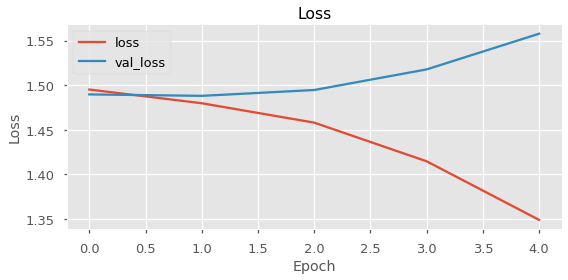

In [20]:
bsb.plot_history(history_no_weights)

In [21]:
# Class weights - Metrics
nnw_start_time = time.time()
nn_weights_test_loss = bsb.print_metrics(
    X_val, 
    y_val, 
    classifier=model_weights, 
    target_names=y_preprocessor.classes_, 
    heading='NN - Class Weights: Validation Data',
    return_loss=True
)
nnw_end_time = time.time()
nnw_elapsed = nnw_end_time - nnw_start_time

********************************************************************************
*                     NN - Class Weights: Validation Data                      *
********************************************************************************
              precision    recall  f1-score   support

          BB       0.15      0.19      0.17    157507
           D       0.05      0.16      0.07     65870
           E       0.01      0.08      0.02     17345
          HR       0.04      0.15      0.06     37797
           I       0.03      0.17      0.05      9139
           K       0.23      0.30      0.26    248202
           O       0.53      0.11      0.18    773273
           S       0.19      0.15      0.17    272584
         SAC       0.12      0.47      0.19     26391
           T       0.01      0.06      0.01      8831

    accuracy                           0.16   1616939
   macro avg       0.14      0.18      0.12   1616939
weighted avg       0.34      0.16      0.18   1616939

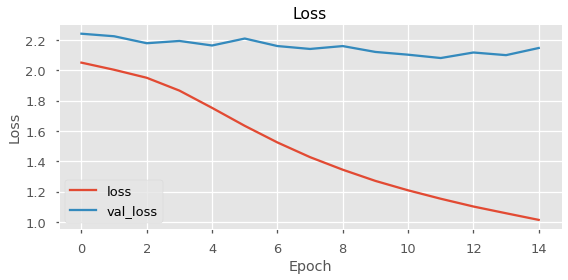

In [22]:
bsb.plot_history(history_cl_weights)

# Comparison

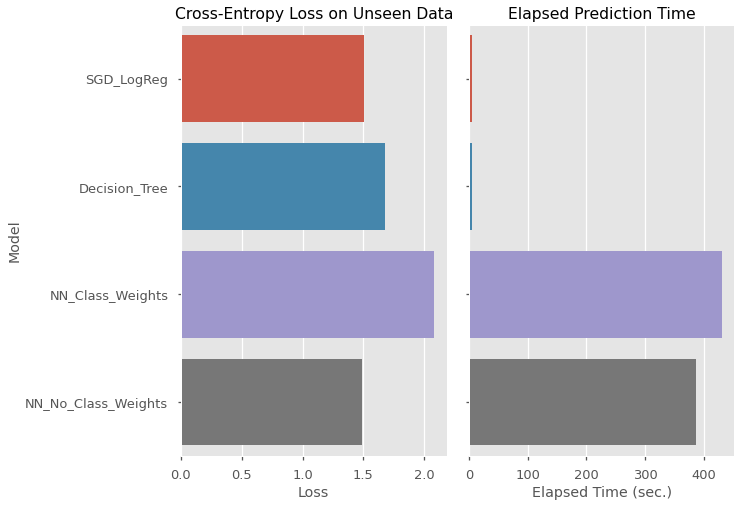

In [23]:
# Visualize comparison.
model_metrics = [
    {'model': 'SGD_LogReg', 
     'loss': sgd_test_loss,
     'time': sgd_elapsed},
    {'model': 'Decision_Tree', 
     'loss': dt_test_loss,
     'time': dt_elapsed},
    {'model': 'NN_Class_Weights', 
     'loss': nn_weights_test_loss,
     'time': nnw_elapsed},
    {'model': 'NN_No_Class_Weights', 
     'loss': nn_no_weights_test_loss,
     'time': nnnw_elapsed}
]

model_df = pd.DataFrame(model_metrics)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.barplot(y='model', x='loss', orient='h', data=model_df, ax=ax1)
ax1.set(title='Cross-Entropy Loss on Unseen Data',
        xlabel='Loss',
        ylabel='Model')
sns.barplot(y='model', x='time', orient='h', data=model_df, ax=ax2)
ax2.set(title='Elapsed Prediction Time',
        xlabel='Elapsed Time (sec.)',
        ylabel='')
fig.tight_layout()
fig.savefig('./images/model_performance.png', transparent=True)

# Validation

To validate, we will set up simulations for two different teams from a given year (we will choose 2010). 

The Yankees (highest-scoring team of the league) and the Mariners (lowest-scoring team of the league) will be simulated with their opening-day lineup against a 'dummy' Pitcher from the league. 

The results of the simulation will be compared to the actual end-of-year stats for the team.

In [24]:
pf = bsb.PlayerFinder()

# Load in "pre-trained" League.
if 'populated_league.pkl' in os.listdir('./data'):
    print('Loading...')
    with open('./data/populated_league_sm.pkl', 'rb') as infile:
        MLB = pickle.load(infile)
    print('Complete.')
    
MLB

Loading...
Complete.



	**********LEAGUE**********
	Number of Hitters:  10104
	Number of Pitchers: 6416
	Total Players:      16520

In [25]:
nn_sim = bsb.Simulator(
    model_no_weights, 
    MLB, 
    X_preprocessor, 
    y_preprocessor, 
    pf)
sgd_sim = bsb.Simulator(
    log_sgd, 
    MLB, 
    X_preprocessor, 
    y_preprocessor, 
    pf)

In [26]:
# Highest-scoring team of 2010
yanks_2010_opening_day_lineup = [
    ('Jeter', 'Derek'),
    ('Johnson', 'Nick'),
    ('Teixeira', 'Mark'),
    ('Rodriguez', 'Alex'),
    ('Cano', 'Robinson'),
    ('Posada', 'Jorge'),
    ('Granderson', 'Curtis'),
    ('Swisher', 'Nick'),
    ('Gardner', 'Brett')
]
    
yanks_2010_ids = [pf.get_player_id(last_n, first_n) 
                  for last_n, first_n in yanks_2010_opening_day_lineup]
yanks_2010_ids

['jeted001',
 'johnn001',
 'teixm001',
 'rodra001',
 'canor001',
 'posaj001',
 'granc001',
 'swisn001',
 'gardb001']

In [27]:
# Lowest-scoring team of 2010.
mariners_2010_opening_day_lineup = [
    ('Suzuki', 'Ichiro'),
    ('Figgins', 'Chone'),
    ('Kotchman', 'Casey'),
    ('Bradley', 'Milton'),
    ('Griffey', 'Ken'),
    ('Lopez', 'Jose'),
    ('Gutierrez', 'Franklin'),
    ('Johnson', 'Rob'),
    ('Wilson', 'Jack'),
]

mariners_2010_ids = [pf.get_player_id(last_n, first_n, 1985) 
                     for last_n, first_n in mariners_2010_opening_day_lineup]
mariners_2010_ids

['suzui001',
 'figgc001',
 'kotcc001',
 'bradm001',
 'grifk002',
 'lopej003',
 'gutif001',
 'johnr009',
 'wilsj002']

In [28]:
# "Dummy" Pitcher to simulate against.
sheets = pf.get_player_id('Sheets', 'Ben')
sheets

'sheeb001'

Running 81 simulations of 9 innings each.
Instructions for updating:
Please use `model.predict()` instead.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.499
Average Runs Scored (/9-inning-game): 4.494


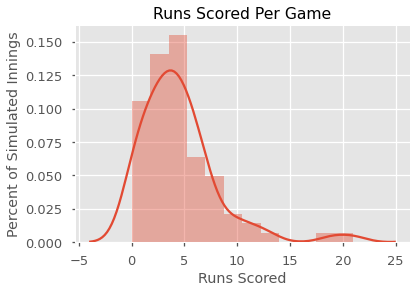

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.55
Average Runs Scored (/9-inning-game): 4.951


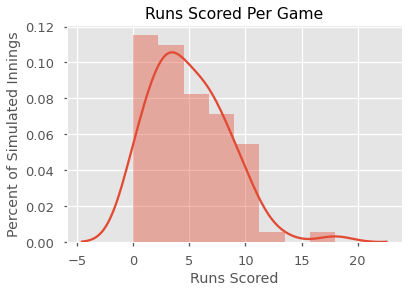

In [29]:
yanks_2010_df_nn, _ = nn_sim.simulate(
    lineup=yanks_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

yanks_2010_df_sgd, _ = sgd_sim.simulate(
    lineup=yanks_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.305
Average Runs Scored (/9-inning-game): 2.741


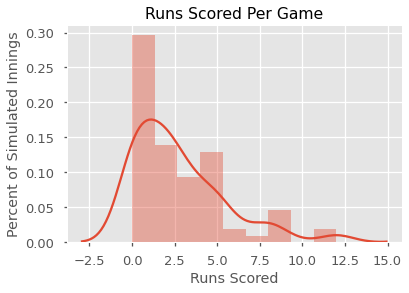

Running 81 simulations of 9 innings each.
********************************************************************************
*                             Simulation Complete                              *
********************************************************************************
81 9-inning simulations run.
Average Runs Scored (/inning): 0.46
Average Runs Scored (/9-inning-game): 4.136


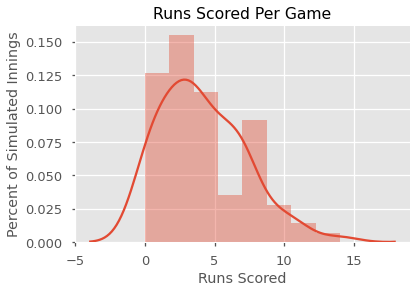

In [30]:
mariners_2010_df_nn, _ = nn_sim.simulate(
    lineup=mariners_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

mariners_2010_df_sgd, _ = sgd_sim.simulate(
    lineup=mariners_2010_ids,
    pitcher_id=sheets,
    inning_num=1,
    inning_half=1,
    use_career_stats=True,
    dblhdr_number=0,
    day_night='night',
    temp=-1,
    wind=-1,
    field_cond='unknown',
    precip='unknown',
    attendance=-1,
    n=81,
    num_innings=9,
    verbose=2
)

In [31]:
def compare_actual_to_simulated(df_actual, df_simulated, team_name=''):
    """
    Compares actual runs scored to simulated runs scored 
    for all home games for a given team.
        `df_actual` should have columns ['Opponent', 'Score']
        `df_simulated` should have column [`simulation_total`]
    """
    
    home_games = df_actual[df_actual['Opponent'].map(
        lambda x: 'vs' in x)].copy()
    actual_runs_scored = home_games['Score'].map(
        lambda x: x.split('-')[1]).astype(int)
    actual_runs_scored.sort_values(inplace=True)
    print('Actual:    Average Runs per Game:', actual_runs_scored.mean())
    
    simulated_runs_scored = df_simulated['simulation_total'].copy()
    simulated_runs_scored.sort_values(inplace=True)
    print('Simulated: Average Runs per Game:', simulated_runs_scored.mean())
    
    mae = mean_absolute_error(
        actual_runs_scored, 
        simulated_runs_scored
    )
    print('Mean Absolute Error:', round(mae, 3))
    
    fig, ax = plt.subplots(figsize=(6,4))
    sns.distplot(actual_runs_scored, color='blue', 
                 ax=ax, label='Actual')
    sns.distplot(simulated_runs_scored, color='green', 
                 ax=ax, label='Simulated')
    ax.set(title=f'{team_name} Runs per Home Game'.strip(),
           xlabel='Runs Scored',
           ylabel='Percent of Games')
    ax.legend()
    fig.tight_layout()
    plt.show()
    fig.savefig(f'./images/{team_name}_comparison.png', transparent=True)

In [32]:
# https://www.baseball-almanac.com/teamstats/schedule.php?y=2010&t=NYA
yankees2010_actual = pd.read_csv('yankees2010_actual.csv', index_col=0)
yankees2010_actual.head()

,Game,Date / Box Score,Opponent,Score,Decision,Record
0,1,04-04-2010,at Boston Red Sox,7-9,L,0-1
1,2,04-06-2010,at Boston Red Sox,6-4,W,1-1
2,3,04-07-2010,at Boston Red Sox,3-1,W,2-1
3,4,04-09-2010,at Tampa Bay Rays,3-9,L,2-2
4,5,04-10-2010,at Tampa Bay Rays,10-0,W,3-2


In [33]:
# https://www.baseball-almanac.com/teamstats/schedule.php?y=2010&t=SEA
mariners2010_actual = pd.read_csv('mariners2010_actual.csv', index_col=0)
mariners2010_actual.head()

,Game,Date / Box Score,Opponent,Score,Decision,Record
0,1,04-05-2010,at Oakland Athletics,5-3,W,1-0
1,2,04-06-2010,at Oakland Athletics,1-2,L,1-1
2,3,04-07-2010,at Oakland Athletics,5-6,L,1-2
3,4,04-08-2010,at Oakland Athletics,2-6,L,1-3
4,5,04-09-2010,at Texas Rangers,2-6,L,1-4


## NN - Actual / Simulated

Actual:    Average Runs per Game: 4.518518518518518
Simulated: Average Runs per Game: 4.493827160493828
Mean Absolute Error: 0.667


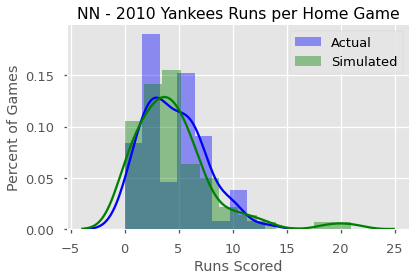

In [34]:
compare_actual_to_simulated(yankees2010_actual, 
                            yanks_2010_df_nn, 
                            'NN - 2010 Yankees')

Actual:    Average Runs per Game: 3.753086419753086
Simulated: Average Runs per Game: 2.740740740740741
Mean Absolute Error: 1.062


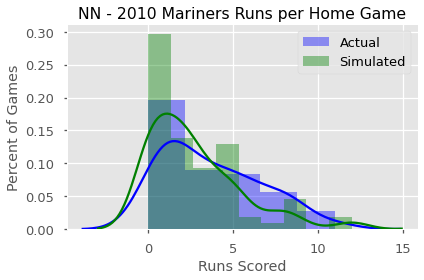

In [35]:
compare_actual_to_simulated(mariners2010_actual, 
                            mariners_2010_df_nn, 
                            'NN - 2010 Mariners')

## SGD - Actual / Simulated

Actual:    Average Runs per Game: 4.518518518518518
Simulated: Average Runs per Game: 4.950617283950617
Mean Absolute Error: 0.58


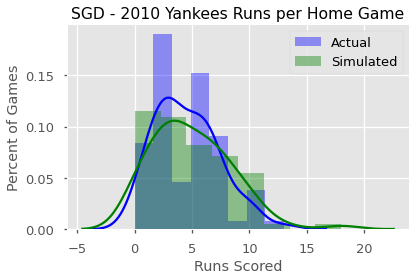

In [36]:
compare_actual_to_simulated(yankees2010_actual, 
                            yanks_2010_df_sgd, 
                            'SGD - 2010 Yankees')

Actual:    Average Runs per Game: 3.753086419753086
Simulated: Average Runs per Game: 4.135802469135802
Mean Absolute Error: 0.556


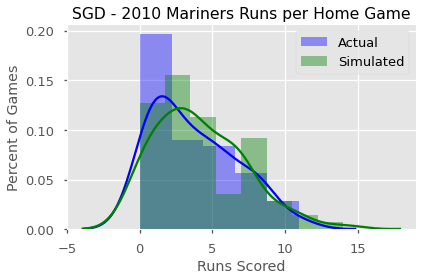

In [37]:
compare_actual_to_simulated(mariners2010_actual, 
                            mariners_2010_df_sgd, 
                            'SGD - 2010 Mariners')

# Batting Order Comparison

In [38]:
def get_n_random_samples(lst, n=100, rand_seed=2021):
    """Returns n (default: 100) samples from a list without replacement."""
    
    np.random.seed(rand_seed)
    
    # Get indices instead of elements so we can work with list of tuples.
    idx_lst = np.random.choice(len(lst), n, replace=False)
    return [lst[i] for i in idx_lst]


def check_samples_expected_runs_scored(batting_orders, 
                                       simulator, 
                                       n_simulations=100,
                                       control_pitcher=''):
    """
    Returns a list of tuples: [(`lineup`, `expected_runs_scored`)].
    Runs {`n_simulations`}-3-inning simulations per lineup.
    `control_pitcher` is a pitcher_id or '' to simulate against.
    """
    
    results = []
    for n, lineup in enumerate(batting_orders, 1):
        if n % 5 == 0:
            print(f'Lineup #{n}')
        df, _ = simulator.simulate(
            lineup=lineup,
            pitcher_id=control_pitcher,
            inning_num=1,
            inning_half=1,
            use_career_stats=True,
            dblhdr_number=0,
            day_night='night',
            temp=-1,
            wind=-1,
            field_cond='unknown',
            precip='unknown',
            attendance=-1,
            n=n_simulations,
            num_innings=3
        )
        expected_runs = df['simulation_total'].sum() / n_simulations
        results.append((lineup, expected_runs))
    return results

In [39]:
random_lineups = get_n_random_samples(list(permutations(yanks_2010_ids)))
random_lineups[:2]

[('gardb001',
  'granc001',
  'teixm001',
  'johnn001',
  'posaj001',
  'rodra001',
  'jeted001',
  'swisn001',
  'canor001'),
 ('gardb001',
  'canor001',
  'swisn001',
  'rodra001',
  'posaj001',
  'johnn001',
  'granc001',
  'jeted001',
  'teixm001')]

In [40]:
####################################
# This cell takes ~40 min. to run. #
####################################

# Find expected runs scored for 100 random lineups
random_sample_expected_runs_scored = check_samples_expected_runs_scored(
    random_lineups,
    nn_sim,
    control_pitcher=sheets
)

random_sample_expected_runs_scored[:2]

Lineup #5
Lineup #10
Lineup #15
Lineup #20
Lineup #25
Lineup #30
Lineup #35
Lineup #40
Lineup #45
Lineup #50
Lineup #55
Lineup #60
Lineup #65
Lineup #70
Lineup #75
Lineup #80
Lineup #85
Lineup #90
Lineup #95
Lineup #100


[(('gardb001',
   'granc001',
   'teixm001',
   'johnn001',
   'posaj001',
   'rodra001',
   'jeted001',
   'swisn001',
   'canor001'),
  1.29),
 (('gardb001',
   'canor001',
   'swisn001',
   'rodra001',
   'posaj001',
   'johnn001',
   'granc001',
   'jeted001',
   'teixm001'),
  1.22)]

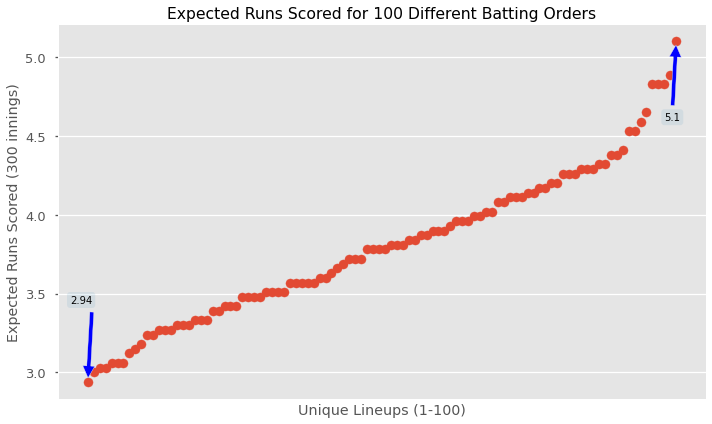

In [46]:
# Expected runs per 3-innings * 3
expected_runs = sorted(
    [(lineup, round(runs*3, 2)) 
     for lineup, runs in random_sample_expected_runs_scored],
    key=lambda x: x[1]
)

# Plot expected runs.
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x=range(len(expected_runs)), y=[x[1] for x in expected_runs])
ax.set_xticks([])
ax.set(
    title='Expected Runs Scored for 100 Different Batting Orders',
    xlabel='Unique Lineups (1-100)',
    ylabel='Expected Runs Scored (300 innings)'
    )
ax.annotate(
    expected_runs[0][1], 
    (0, expected_runs[0][1]),
    xytext=(-3, expected_runs[0][1]+.5),
    bbox=dict(boxstyle="round", alpha=0.1), 
    arrowprops=dict(facecolor='blue', shrink=0.05)
    )
ax.annotate(
    expected_runs[-1][1], 
    (99, expected_runs[-1][1]),
    xytext=(97, expected_runs[-1][1]-.5),
    bbox=dict(boxstyle="round", alpha=0.1), 
    arrowprops=dict(facecolor='blue', shrink=0.05)
    )

fig.tight_layout()
fig.savefig('./images/lineup_samples_ev.png', transparent=True)

In [47]:
def show_players_from(lst):
    """Prints a formatted list of player names from a list."""
    
    for i, player in enumerate(lst, 1):
        print(f'\t{i}. {player}')


lowest_scoring = [pf.get_player_name(p_id) for p_id in expected_runs[0][0]]
highest_scoring = [pf.get_player_name(p_id) for p_id in expected_runs[-1][0]]

print('Lowest Scoring Lineup:')
show_players_from(lowest_scoring)

print()
print('Highest Scoring Lineup:')
show_players_from(highest_scoring)

Lowest Scoring Lineup:
	1. Curtis Granderson
	2. Nick Johnson
	3. Alex Rodriguez
	4. Robinson Cano
	5. Derek Jeter
	6. Mark Teixeira
	7. Jorge Posada
	8. Nick Swisher
	9. Brett Gardner

Highest Scoring Lineup:
	1. Brett Gardner
	2. Jorge Posada
	3. Robinson Cano
	4. Derek Jeter
	5. Mark Teixeira
	6. Curtis Granderson
	7. Alex Rodriguez
	8. Nick Johnson
	9. Nick Swisher


# Modeling Conclusions

- The cross-entropy loss may have been slightly better for the FFNN without class weights, the balance between strength, size, and performance leads us to the SGD LogReg model.
- A neural network is very prone to overfitting, so the number of training epochs should be small. It does no good for the network to just "memorize" the training data.
- Additionally, adding in class weights hurts performance. It is a similar case of overfitting.
  - For example, if the model is rewarded too strongly for predicting a catcher's interference, it will behave very poorly - i.e.: predict that there's an 80% chance that in the upcoming play, the catcher will interfere with the batter. It is clear that this is not ideal behavior of the model.
- We can conclusively say that the batting order makes a difference in expected runs scored. With 100 randomly selected permutations of a lineup, after running simulations totaling 300-innings the differences were dramatic.

# Conclusions and Recommendations: `capstone.ipynb`

The conclusion of the project can be found back in the original notebook.